In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import lightgbm as lgb # Import LightGBM
import shap
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import roc_auc_score, roc_curve

# Reproducibility seeds
np.random.seed(87)

In [3]:
# --- Data Loading and Preprocessing ---
df = pd.read_csv('cleaned_casedata.csv')

if 'Unnamed: 0' in df.columns:
    df = df.drop(['Unnamed: 0'], axis=1)

# --- Feature Engineering ---
ext_source_cols = ['EXT_SOURCE_2', 'EXT_SOURCE_3']
existing_ext_cols = [col for col in ext_source_cols if col in df.columns]
if existing_ext_cols:
    df['EXT_SOURCE_AVG'] = df[existing_ext_cols].mean(axis=1)


In [4]:
# --- Prepare data for model ---
X = df.drop(columns=["TARGET"])
Y = df["TARGET"]


# --- Imputation and Data Type Conversion for LightGBM ---
# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

print("Imputing missing values and setting data types...")
# Fill missing values in categorical columns with the string 'Missing'
X[categorical_features] = X[categorical_features].fillna('Missing')

# KEY CHANGE for LightGBM: Convert object columns to 'category' dtype
# This is the most efficient way to let LightGBM handle them.
for col in categorical_features:
    X[col] = X[col].astype('category')

# Fill missing values in numerical columns with their respective medians
X[numerical_features] = X[numerical_features].fillna(X[numerical_features].median())

# Verification step: Ensure no missing values remain
assert X.isnull().sum().sum() == 0, "Error: Missing values still exist after imputation!"
print("Successfully handled all missing values.")


Imputing missing values and setting data types...
Successfully handled all missing values.


In [5]:
# --- Split into train/test sets ---
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=99,
    shuffle=True,
    stratify=Y
)

# --- LightGBM Model Training and Tuning ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Define the LightGBM model
# KEY CHANGE: Using LGBMClassifier
model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    is_unbalance=True, # Handles class imbalance
    random_state=99,
    n_jobs=-1
)

# Create a hyperparameter grid specific to LightGBM
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [20, 31], # Max number of leaves in one tree
    'max_depth': [5, 7],    # Max tree depth
}

# Run cross-validated grid search
lgb_cv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True,
    verbose=1
)

lgb_cv.fit(X_train, Y_train)

print("\nBest params selected by CV:", lgb_cv.best_params_)
print("Best CV ROC-AUC:", round(lgb_cv.best_score_, 3))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Number of positive: 1084, number of negative: 12916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077429 -> initscore=-2.477809
[LightGBM] [Info] Start training from score -2.477809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -


Top 15 features:
                       feature  importance
43              EXT_SOURCE_AVG         506
7                  AMT_ANNUITY         384
33                EXT_SOURCE_3         378
36      DAYS_LAST_PHONE_CHANGE         376
32                EXT_SOURCE_2         359
44                         AGE         319
15               DAYS_EMPLOYED         305
6                   AMT_CREDIT         292
14  REGION_POPULATION_RELATIVE         276
45          REGISTRATION_YEARS         268
8              AMT_GOODS_PRICE         265
5             AMT_INCOME_TOTAL         260
46            ID_PUBLISH_YEARS         195
25     HOUR_APPR_PROCESS_START         173
24  WEEKDAY_APPR_PROCESS_START         129


<Figure size 1000x700 with 0 Axes>

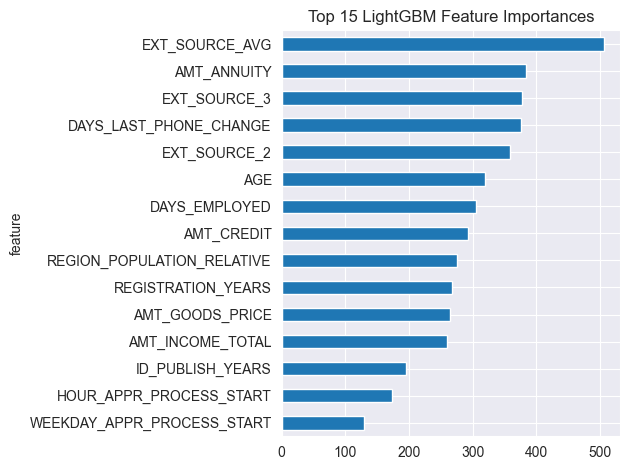

In [6]:
# --- Feature Importance Plot ---
best_lgb = lgb_cv.best_estimator_
importances = best_lgb.feature_importances_
features = X_train.columns

feat_imp = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\nTop 15 features:")
print(feat_imp.head(15))

plt.figure(figsize=(10, 7))
feat_imp.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 LightGBM Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



ROC AUC on Test Set: 0.709


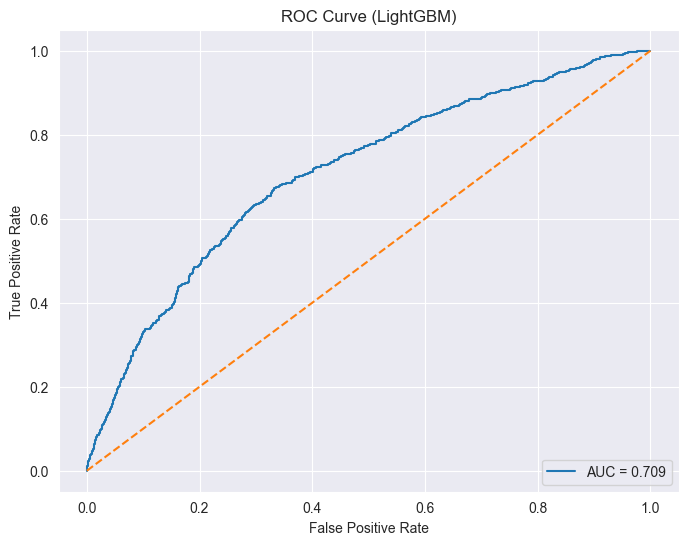

In [7]:
# --- ROC Curve and AUC Score ---
proba = lgb_cv.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(Y_test, proba)
print(f"\nROC AUC on Test Set: {roc_auc:.3f}")

fpr, tpr, _ = roc_curve(Y_test, proba, pos_label=1)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (LightGBM)")
plt.legend(loc="lower right")
plt.show()

In [8]:
# --- SHAP Analysis ---
print("\n--- Generating SHAP Analysis ---")

explainer = shap.TreeExplainer(best_lgb)
shap_values = explainer.shap_values(X_test)

print("Generating SHAP summary plot...")
# SHAP for binary classification returns a list [values_for_class_0, values_for_class_1]
# We are interested in explaining the prediction for the positive class (1)
shap.summary_plot(shap_values[1], X_test)



--- Generating SHAP Analysis ---


C:\Users\miyee\anaconda3\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\miyee\AppData\Local\Temp\ipykernel_24408\3659750492.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[1], X_test)


Generating SHAP summary plot...


AssertionError: Summary plots need a matrix of shap_values, not a vector.

<Figure size 640x480 with 0 Axes>